In [360]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os
%run helpers_preproc.ipynb
%run alternate_data.ipynb

In [361]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/'

In [362]:
#generate additional data and update label
origLabel = np.array(readLbl(600,origDataDir + 'labels.txt'),dtype = int) #first take in the original labels
newLabelFile = open(newDataDir + "labels.txt", "w")

In [363]:
radiuss = [0.002]

for i in range(600):
    #First create the new obj file
    origN = origDataDir + 'T' + str(i) + '.obj'
    
    for j in range(len(radiuss)):
        radius = radiuss[j]
        newN = newDataDir + 'T' + str(i+600*(j)) + '.obj'
    
        #newLabelFile.write("T" + str(i) + ".obj" + " " + str(origLabel[i]) + "\n")
        if not (write_new_files(origN,newN,radius)):
            print('Data generation failed on ' , i)
        
        newLabelFile.write("T" + str(i + 600*(j)) + ".obj" + " " + str(origLabel[i]) + "\n")

    
newLabelFile.close()

In [364]:
#read in the data, get normalized adjacency (NxN)
num_meshes = 600 * 1
train_size = 450 * 1
test_size = 150 * 1
mesh_dir = 'SHREC11_plus/'

In [365]:
num_swaps = 10000

labels = np.array(readLbl(num_meshes,mesh_dir+'labels.txt'))

for swap_idx in range(num_swaps):
    idxA = random.randint(0,num_meshes-1)
    idxB = random.randint(0,num_meshes-1)
    
    if idxA != idxB:
        labelA = labels[idxA]
        labelB = labels[idxB]
        labels[idxA] = labelB
        labels[idxB] = labelA

        #change filenames
        os.rename(mesh_dir+'T' + str(idxA) + '.obj',mesh_dir+'temp.obj')
        os.rename(mesh_dir+'T' + str(idxB) + '.obj',mesh_dir+'T' + str(idxA) + '.obj')
        os.rename(mesh_dir+'temp.obj',mesh_dir+'T' + str(idxB) + '.obj')

newLabelFile = open(newDataDir + "labels.txt", "w")
for i in range(num_meshes):
        newLabelFile.write("T" + str(i) + ".obj" + " " + str(labels[i]) + "\n")


newLabelFile.close()

In [366]:
label_np = np.array(readLbl(num_meshes,mesh_dir+'labels.txt'))

In [367]:
node_sigs_list = []
normed_adjMats_list = []

for i in range(num_meshes):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    
    node_sigs_list.append(node_sig)
    normed_adjMats_list.append(adj_normalized)

In [368]:
normed_adjMats = np.nan_to_num(np.stack(normed_adjMats_list))
node_sigs = np.nan_to_num(np.stack(node_sigs_list))

In [369]:
#feature_mean = np.reshape(np.mean(node_sigs,axis = 1),[num_meshes,1,5])
#node_sigs = node_sigs - feature_mean 

In [370]:
node_sigs

array([[[1.01666667, 0.2       , 0.        , 0.7       , 0.7       ],
        [0.90833333, 0.25      , 0.        , 1.15      , 1.15      ],
        [1.1       , 0.25      , 0.        , 1.12619048, 1.12619048],
        ...,
        [0.90238095, 0.25      , 0.        , 0.95      , 0.95      ],
        [0.78571429, 0.25      , 0.        , 1.06904762, 1.06904762],
        [1.13690476, 0.2       , 0.        , 0.70952381, 0.70952381]],

       [[6.        , 0.13083749, 0.        , 0.42281979, 0.42281979],
        [6.        , 0.11924384, 0.        , 0.37725996, 0.37725996],
        [8.        , 0.1161383 , 0.        , 0.54852733, 0.54852733],
        ...,
        [6.        , 0.08956612, 0.        , 0.3562267 , 0.3562267 ],
        [5.        , 0.07652732, 0.        , 0.28861471, 0.28861471],
        [6.        , 0.0865558 , 0.        , 0.33945932, 0.33945932]],

       [[4.        , 0.11824643, 0.        , 0.4168013 , 0.4168013 ],
        [6.        , 0.14461065, 0.        , 0.67724229, 0.6

In [371]:
normed_adjMats_tr = normed_adjMats[:train_size,:,:]
node_sigs_tr = node_sigs[:train_size,:,:]
label_np_tr = label_np[:train_size]

normed_adjMats_ts = normed_adjMats[train_size:,:,:]
node_sigs_ts = node_sigs[train_size:,:,:]
label_np_ts = label_np[train_size:]

label_mat_tr = torch.tensor(np.where(igl.all_pairs_distances(label_np_tr,label_np_tr,False) > 0.5,0,1)).float()
label_mat_ts = torch.tensor(np.where(igl.all_pairs_distances(label_np_ts,label_np_ts,False) > 0.5,0,1)).float()

In [372]:
normed_adjMats_tr = torch.tensor(normed_adjMats_tr).float()
node_sigs_tr = torch.tensor(node_sigs_tr).float()
label_np_tr = torch.tensor(label_np_tr).float()

normed_adjMats_ts = torch.tensor(normed_adjMats_ts).float()
node_sigs_ts = torch.tensor(node_sigs_ts).float()
label_np_ts = torch.tensor(label_np_ts).float()

In [373]:
#label_mat_train = form_label_matrix(label_mat, train_dict)

In [374]:
#normed_adjMats_list_train, node_sigs_list_train = prep_data(train_dict)

In [375]:
#normed_adjMats_train = np.stack(normed_adjMats_list_train)
#node_sigs_train = np.stack(node_sigs_list_train)

#normed_adjMats_train = torch.tensor(normed_adjMats_train,requires_grad=False).float()
#node_sigs_train = torch.tensor(node_sigs_train,requires_grad=False).float()

#normed_adjMats_train = torch.nan_to_num(normed_adjMats_train,0,0,0)
#node_sigs_train = torch.nan_to_num(node_sigs_train,0,0,0)

In [376]:
node_sigs_tr.shape

torch.Size([450, 252, 5])

In [402]:
%run NNs.ipynb
g = GCN(5,[16,32,32,16])
n = MLP(252*16,[8,16,16,8])
output1 = g.forward(normed_adjMats_tr,node_sigs_tr)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

torch.Size([450, 252, 16])
torch.Size([450, 8])


In [403]:
def useless():
    pass

def lossF(features,lbl_mat):
    disMat = torch.cdist(features,features)
    sameType = disMat * (lbl_mat-torch.diag(torch.ones(lbl_mat.shape[0])))
    diffType = disMat * (1-lbl_mat)

    diffTypeScaled = diffType * torch.exp(-diffType)
    diffTypeScaledMean = torch.sum(diffTypeScaled)/ torch.count_nonzero(diffTypeScaled)
    diffTypeMean = torch.sum(diffType)/ torch.count_nonzero(diffType)

    sameTypeMean = torch.sum(sameType) / torch.count_nonzero(sameType)
    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / torch.count_nonzero(sameType)

    toRet = sameTypeMean-diffTypeScaledMean# + 0.01 * torch.sqrt(sameTypeStd)
    
    print(sameTypeMean.detach().numpy(),diffTypeMean.detach().numpy(),torch.sqrt(sameTypeStd).detach().numpy(), toRet.detach().numpy())
    return  toRet

In [404]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.00001)
for i in range(100000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
    loss = lossF(output,label_mat_tr)
    loss.backward()
    optimizer.step()

0.38286057 0.40121177 2.1625829 0.17664747
0.3952645 0.40113348 2.228191 0.18925084
0.40050912 0.41703776 2.254119 0.18642169
0.40684438 0.42143217 2.289921 0.19259992
0.3868647 0.40040064 2.1777945 0.17805383
0.37810093 0.3895404 2.1312916 0.17615019
0.37214428 0.38628715 2.095852 0.16636516
0.39485887 0.4123802 2.2236161 0.18210186
0.36717263 0.37806496 2.0712502 0.16716155
0.3972832 0.40789327 2.2357855 0.1872349
0.41634473 0.4220056 2.3409638 0.1986745
0.3969748 0.411152 2.2344248 0.18556437
0.36388427 0.3734413 2.0524933 0.16406791
0.3909511 0.40483373 2.200482 0.18129827
0.39988467 0.40632945 2.2492769 0.187612
0.39776766 0.4093246 2.238835 0.18370688
0.35455516 0.36718738 2.0000591 0.15752886
0.39675114 0.40295535 2.2312028 0.18641652
0.37539488 0.3878066 2.116986 0.17280218
0.36098716 0.3719785 2.0388608 0.16332398
0.3818862 0.39460477 2.1560571 0.1792715
0.38666636 0.38995105 2.179243 0.18239276
0.3480906 0.35421953 1.9660009 0.15782668
0.3852426 0.39306876 2.1682785 0.1794398

0.3395353 0.3444598 1.9198494 0.15277773
0.3296568 0.334329 1.8674747 0.1505746
0.38126224 0.38635263 2.1517055 0.184211
0.39214614 0.3956783 2.2093012 0.18514344
0.33253673 0.3400018 1.879015 0.14716399
0.32671657 0.33283094 1.8462596 0.14213008
0.35688493 0.36475724 2.0128868 0.15913667
0.3599333 0.3646832 2.0299702 0.16066694
0.34789184 0.35416338 1.9648687 0.1570522
0.3743685 0.3776071 2.109087 0.17248096
0.31383163 0.31851155 1.7741256 0.13646178
0.37160632 0.38412622 2.0976307 0.16896752
0.3436814 0.3497051 1.9413753 0.15504831
0.36147982 0.36589286 2.0380187 0.16433795
0.3564003 0.36304754 2.0121737 0.16153696
0.34848896 0.35410705 1.9677794 0.16011274
0.36999616 0.37349734 2.0841994 0.16854729
0.36419728 0.36695758 2.057999 0.17486773
0.36483085 0.37333336 2.057902 0.16699697
0.33951852 0.3453147 1.9186974 0.1525832
0.35087952 0.3591745 1.9817519 0.1576741
0.33225253 0.34452102 1.880811 0.14339268
0.3672262 0.38318035 2.072022 0.16573778
0.40132818 0.40076244 2.256288 0.1897750

0.32995316 0.33755925 1.8610425 0.14294454
0.31877798 0.32929188 1.8018665 0.13753296
0.35419515 0.359837 1.9919658 0.15352143
0.34865206 0.35149482 1.961631 0.1494966
0.30962488 0.31605306 1.7476369 0.12918478
0.33629143 0.34507304 1.8969504 0.1417271
0.34445646 0.3528181 1.9397166 0.14671084
0.335605 0.34170622 1.8916208 0.1465009
0.37817302 0.3803726 2.129904 0.17433895
0.34715712 0.34772685 1.9577637 0.1531207
0.33470717 0.3404419 1.8872464 0.14370054
0.34655645 0.34653637 1.9517592 0.15217291
0.33227697 0.33778286 1.8733127 0.14148703
0.32534742 0.33065546 1.8328875 0.13469157
0.3339617 0.34351313 1.8816997 0.1418841
0.34730065 0.3518074 1.9579132 0.15397725
0.31141397 0.31372717 1.7593428 0.1327905
0.33019945 0.33200872 1.860941 0.14258029
0.3388097 0.3494511 1.9123716 0.14524204
0.3672846 0.3699122 2.0668926 0.1670849
0.34180483 0.34250838 1.9276496 0.15315111
0.3416332 0.34654906 1.9286085 0.15171845
0.33470756 0.3352696 1.8874305 0.14590815
0.31058407 0.31640068 1.7553492 0.13

0.33794913 0.33853802 1.9032921 0.14222921
0.34788662 0.35481152 1.9566284 0.14555436
0.31714967 0.32341418 1.783572 0.12717998
0.34001037 0.35101274 1.9155116 0.14122775
0.3179974 0.3242277 1.7928332 0.13058421
0.32522628 0.32889163 1.8324611 0.13646401
0.33833897 0.3466476 1.902796 0.13963506
0.31776372 0.32659978 1.7904638 0.12670675
0.28984377 0.2978754 1.6375567 0.11458863
0.31571004 0.3250611 1.7798887 0.12714379
0.30500752 0.31452197 1.7175031 0.119873434
0.32759103 0.33322856 1.8453108 0.13627501
0.32254246 0.3287043 1.8144313 0.13098086
0.3103457 0.31556916 1.7468514 0.12358099
0.31546798 0.32495084 1.7763071 0.12875453
0.2993843 0.31009683 1.6858952 0.113580614
0.3265871 0.33427227 1.8349042 0.12754866
0.34594166 0.3556178 1.9438196 0.14145726
0.3014565 0.31681582 1.6978309 0.11452825
0.33755428 0.35413396 1.8999816 0.13743453
0.34882644 0.35924724 1.9602368 0.1424688
0.33393338 0.35316542 1.8781873 0.13144836
0.33691734 0.340002 1.8937136 0.1369494
0.32631135 0.33735448 1.83

0.2787217 0.2994159 1.5689069 0.09218313
0.31680933 0.33058575 1.7783973 0.11558609
0.31209826 0.3297903 1.7536925 0.11357516
0.30047604 0.32749408 1.6870954 0.09884374
0.33010578 0.34632936 1.8528234 0.12276833
0.34992206 0.36156654 1.966055 0.13883258
0.3063932 0.3185296 1.7188545 0.10825631
0.33758858 0.35465783 1.8946543 0.1252019
0.30380034 0.31821418 1.7056955 0.10884583
0.32349864 0.33598247 1.8154862 0.11909272
0.3222524 0.33617893 1.8091671 0.11890851
0.36121592 0.3750204 2.0236444 0.14284502
0.33749202 0.35475314 1.8929859 0.12794383
0.31662926 0.33197132 1.7776377 0.11242093
0.33506778 0.3596556 1.8832495 0.12479915
0.34299076 0.35757732 1.9274751 0.13466342
0.33929574 0.356565 1.90566 0.13187276
0.34322673 0.35852394 1.9271121 0.13316666
0.3345536 0.349589 1.8763955 0.12489356
0.32206637 0.34090552 1.8074623 0.11774418
0.29840127 0.3104367 1.6783916 0.10606478
0.34209436 0.3653395 1.9181675 0.12669729
0.32047415 0.34043667 1.7994832 0.11550583
0.31830147 0.3332565 1.7857071

KeyboardInterrupt: 

In [380]:
output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
output.shape

torch.Size([450, 4])

In [381]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(train_size)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_62913/1331210453.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(train_size)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_62913/1331210453.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()


0.091453545 0.1532246


Text(0.5, 1.0, 'Diff Comp')

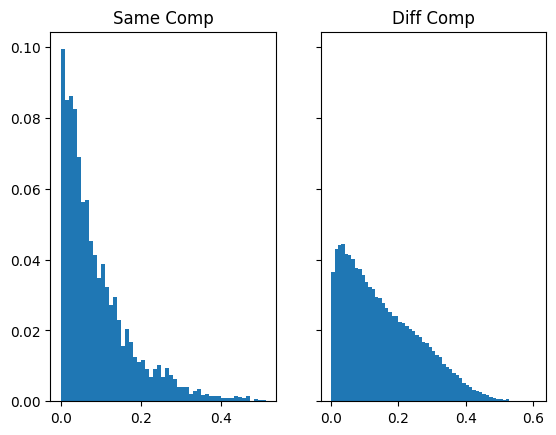

In [382]:
print(np.mean(sameComp),np.mean(diffComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [383]:
output = n.forward(g.forward(normed_adjMats_ts,node_sigs_ts))
output.shape

torch.Size([150, 4])

In [384]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(test_size)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_62913/923068292.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(test_size)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_62913/923068292.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()


0.08364512 0.15117119


Text(0.5, 1.0, 'Diff Comp')

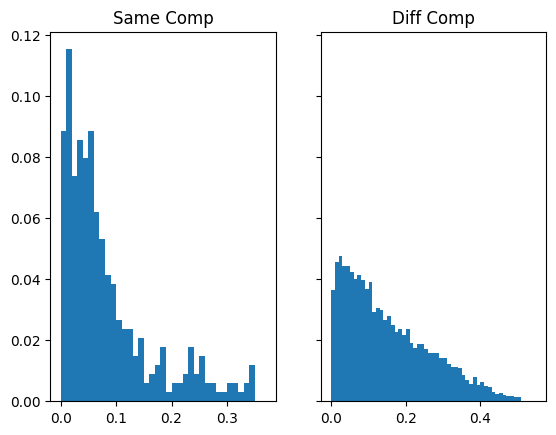

In [385]:
print(np.mean(sameComp),np.mean(diffComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [279]:
#from matplotlib.pyplot import figure
#figure(figsize=(10, 8), dpi=80)


In [286]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.75)[0].tolist()

In [287]:
len(BigDiffIndices)

168784

In [288]:
vizMat = np.zeros([30,30])

In [289]:
for index in BigDiffIndices:
    row, col = divmod(index,test_size)
    cat1, cat2 = int(label_np_ts[row]),int(label_np_ts[col])
    if cat1 == cat2:
        print(cat1, cat2)
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


5 5
5 5
19 19
19 19
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
21 21
21 21
21 21
21 21
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
28 28
28 28
28 28
28 28
6 6
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
28 28
21 21
21 21
21 21
21 21
5 5
21 21
21 21
21 21
21 21
24 24
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
19 19
19 19
28 28
28 28
28 28
28 28
5 5
24 24
6 6
6 6
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
5 5
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
19 19
24 24
21 21
21 21
21 21
21 21
19 19
19 19
28 28
28 28
28 28
28 28
21 21
21 21
21 21
21 21
5 5
24 24
28 28
28 28
28 28
28 28
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
28 28
28 28


In [290]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.        , 0.        , 0.        , 0.        , 0.44378698,
        0.56213018, 0.0295858 , 0.        , 0.        , 0.        ,
        0.71005917, 0.        , 0.        , 0.        , 0.        ,
        0.32544379, 0.65088757, 0.        , 0.65088757, 0.0295858 ,
        0.76923077, 0.44378698, 0.        , 0.65088757, 0.36094675,
        0.56213018, 0.        , 0.73964497, 0.1183432 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.37721893,
        0.47781065, 0.02514793, 0.        , 0.        , 0.        ,
        0.6035503 , 0.        , 0.        , 0.        , 0.        ,
        0.27662722, 0.55325444, 0.        , 0.55325444, 0.02514793,
        0.65384615, 0.37721893, 0.        , 0.55325444, 0.30473373,
        0.47781065, 0.        , 0.62869822, 0.10059172, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.44674556,
        0.56213018, 0.0295858 , 0.        , 0.        , 0.        ,
        0.71449704, 0.        , 0.        , 0.

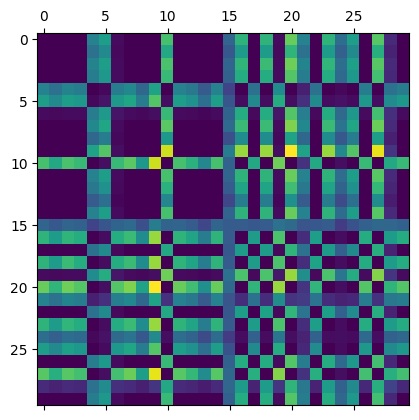

In [291]:
plt.matshow(vizMat)

In [292]:
features = output.detach().numpy()

In [293]:
features.shape

(600, 4)

In [294]:
from sklearn.decomposition import PCA

In [295]:
pca = PCA(n_components=3)
newX = pca.fit_transform(features)
np.sum(pca.explained_variance_ratio_)

0.9999926

In [296]:
newX.shape

(600, 3)

In [302]:
marker_color_indices_raw = list(label_np_ts.numpy())
marker_color_indices = []

for i in range(len(marker_color_indices_raw)):
    _, new_color = divmod(marker_color_indices_raw[i],5)
    print(int(new_color))
    marker_color_indices.append(int(new_color))

0
3
3
2
0
0
0
1
0
4
1
2
2
4
0
2
4
4
4
2
3
4
0
1
2
2
2
1
2
1
4
1
4
3
3
3
2
2
4
0
0
4
2
1
0
1
2
2
3
0
1
0
3
0
3
1
2
2
1
2
2
1
0
2
0
3
3
2
1
2
2
3
3
0
2
2
3
0
0
2
0
2
4
1
4
4
4
4
1
3
1
3
4
0
1
2
2
2
1
0
2
0
4
0
0
0
0
4
3
1
0
1
4
0
1
3
1
2
3
2
2
1
0
1
3
1
0
4
3
0
0
0
2
1
0
3
3
1
0
0
4
1
4
0
2
3
0
2
2
4
4
2
3
1
4
4
2
1
3
3
4
2
4
3
1
3
3
2
0
1
4
1
3
3
0
0
0
3
4
1
3
0
3
4
2
4
0
2
1
2
3
3
0
0
3
1
4
1
1
1
0
0
0
1
4
4
4
2
4
0
0
4
3
2
3
4
1
1
0
1
2
0
4
1
3
1
1
1
1
4
3
3
1
3
1
2
1
2
4
2
0
3
1
2
3
0
0
2
1
2
4
0
0
2
2
3
2
3
3
3
0
1
1
0
2
1
2
0
4
4
0
4
3
0
0
4
1
4
1
1
3
2
2
0
0
2
1
2
4
2
4
3
3
1
0
3
1
4
4
2
0
3
3
3
0
1
4
2
0
0
1
3
2
2
2
3
0
1
4
4
2
3
3
3
3
4
1
3
3
3
1
4
3
1
0
4
2
4
0
0
2
4
2
2
2
4
4
4
4
3
4
0
0
1
2
2
0
1
4
0
4
3
3
1
1
0
1
0
4
2
0
1
1
1
0
1
2
1
4
1
1
3
3
4
0
1
3
4
3
3
4
4
4
1
4
0
4
0
3
2
0
4
0
0
3
2
1
3
4
4
0
2
0
4
3
2
1
4
3
2
2
4
1
3
0
2
4
3
2
0
1
3
4
3
0
3
2
1
1
4
0
0
3
1
0
2
2
1
3
2
1
0
4
4
3
1
2
2
2
0
2
0
4
2
1
3
0
1
0
2
0
4
1
1
3
4
3
4
3
4
3
1
1
4
2
2
3
3
3
4
1
1
1
1
1
0
3
4
2
1


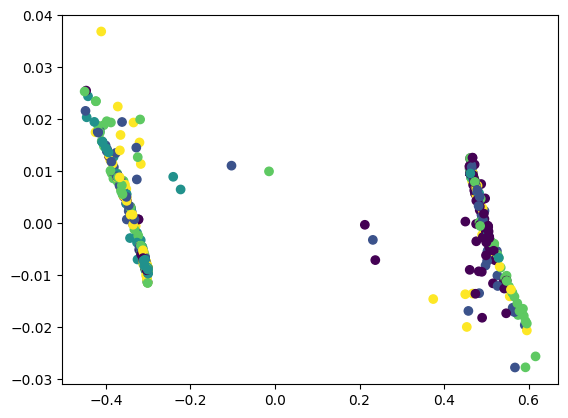

In [303]:
plt.scatter(newX[:,0],newX[:,1],c = marker_color_indices)

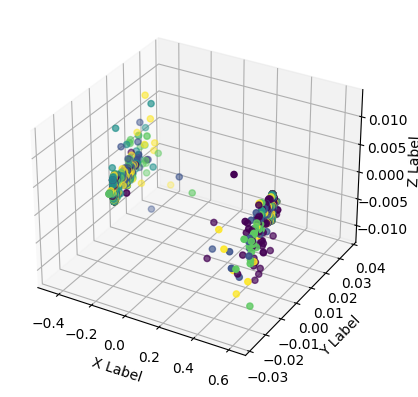

In [304]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.scatter(newX[:,0], newX[:,1], newX[:,2], c=marker_color_indices)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
